In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
# import pyLDAvis.gensim  # don't skip this
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

import nltk; nltk.download('stopwords')
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])



# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint


# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.filterwarnings("ignore") #ignore warnings

import mysql.connector
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity
#from mysql.connector import Error

from sqlalchemy import create_engine


import pymysql

from wordcloud import WordCloud


sqlEngine       = create_engine('mysql+pymysql://root:@127.0.0.1', pool_recycle=3600)

dbConnection    = sqlEngine.connect()

frame           = pd.read_sql("select id ,message from enron_email.message_data", dbConnection);

#r_tips          = pd.read_sql("select tips from foursquare.sentiment_data", dbConnection);


pd.set_option('display.expand_frame_repr', False)



dbConnection.close()

data = frame
data.head()

C:\Users\nischal\Anaconda3\lib\site-packages\nltk\decorators.py:68: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  regargs, varargs, varkwargs, defaults, formatvalue=lambda value: ""
C:\Users\nischal\Anaconda3\lib\site-packages\nltk\lm\counter.py:15: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence, defaultdict
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nischal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,id,message
0,1,dave name west desk member categori origin sid...
1,2,paula million fine phillip
2,3,brenda second check octob payment toss know ma...
3,4,think fletch good cpa
4,5,brenda second check octob payment copi origin ...


In [2]:
data.shape

(418631, 2)

In [3]:
tdata = data.message.values.tolist()# Remove new line characters


tdata[:5]

['dave name west desk member categori origin side spars phillip',
 'paula million fine phillip',
 'brenda second check octob payment toss know mail phillip',
 'think fletch good cpa',
 'brenda second check octob payment copi origin deal fax phillip',
 'todai copi bloomberg power line adob acrobat reader requir view attach file download free version acrobat reader troubl download attach file locat don forget check bloomberg powermatch west coast indic accur indic index valu calcul actual tra de audit powermatch custom aim bring time electr market coverag industri welcom feedback improv product bloomberg energi depart bloomberg daili power report tabl bloomberg region electr price mwh mwh pre schedul packag transmiss cost peak west coast index chang low high mid columbia ca border np sp ault colorado mead palo verd four corner mid contin ecar east aep west central cinergi south north main ed lower mapp north lower gulf coast spp northern ercot serc va power vacar tva tva entergi southern

In [4]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,                        # minimum reqd occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             max_features=1000,             # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(tdata)

In [5]:
# tdata=None
# data=None

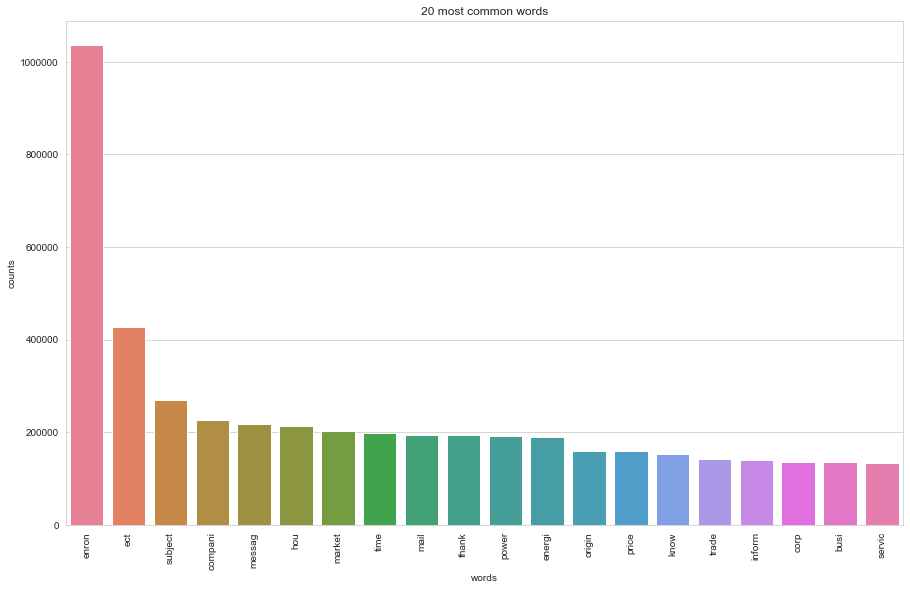

In [6]:
#mostcommon words

import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
#     count_dict1 = sorted(count_dict, key=lambda x:x[1], reverse=True)[2:400]
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:20]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='20 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()
    return count_dict


# Visualise the 10 most common words
count_dict1=plot_10_most_common_words(data_vectorized, vectorizer)

In [7]:
def Convert(tup, di): 
    for a, b in tup: 
        di.setdefault(a, b)
    return di 
      

dictionary = {} 
dictionary=Convert(count_dict1, dictionary)
dictionary

{'enron': 1036512.0,
 'ect': 426749.0,
 'subject': 269682.0,
 'compani': 226304.0,
 'messag': 216931.0,
 'hou': 212430.0,
 'market': 203137.0,
 'time': 198503.0,
 'mail': 194450.0,
 'thank': 193706.0,
 'power': 191650.0,
 'energi': 189302.0,
 'origin': 159991.0,
 'price': 159427.0,
 'know': 152873.0,
 'trade': 141279.0,
 'inform': 139186.0,
 'corp': 136091.0,
 'busi': 135515.0,
 'servic': 132463.0}

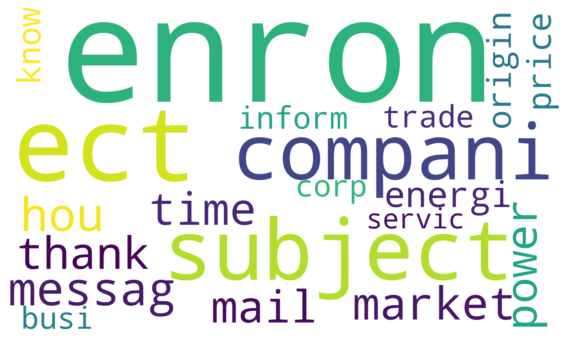

In [8]:
from PIL import Image
import matplotlib.pyplot as plt

wc = WordCloud(background_color="white",width=1700,height=1000, relative_scaling=0.5,normalize_plurals=False).generate_from_frequencies(dictionary)
plt.figure(figsize=(10, 7)) 
plt.imshow(wc, interpolation="bilinear") 
plt.axis('off') 
plt.show()

In [9]:
# Build LDA Model
lda_model = LatentDirichletAllocation(n_components=20,               # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )


In [10]:
lda_output = lda_model.fit_transform(data_vectorized)

In [11]:
def print_top_words(model, vectorizer, n_top_words):
    feature_names = vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        message = "\nTopic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [12]:
print_top_words(lda_model, vectorizer, n_top_words=25)


Topic #0: state new jone dow court right copyright reserv sai law tran govern offici feder senat bush nation releas press bankruptci tax prefer presid compani public

Topic #1: deal trade credit confirm ena price term sale chang option volum risk carol contract trader clair financi march deliveri transact june desk fare month point

Topic #2: agreement contract document legal kai chang execut parti entiti form account payment file letter comment discuss agre review requir question expens propos purchas pai order

Topic #3: report updat book question swap futur daili chang jan post nymex index free month expect posit care close spread pass list end exchang chart number

Topic #4: origin messag subject octob mondai tuesdai novemb thursdai wednesdai mailto fridai thank januari septemb august mike juli decemb michel know attach llc dave nelson edu

Topic #5: enron ect hou corp subject sara develop enronxg shackleton houston commun lai america forward smith north mark richard lon jeff pdx 

In [14]:
# Create Document - Topic Matrix # same as doc_topic_dists as above
lda_output = lda_model.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(data))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=data['id'])

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)

In [16]:
# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

df_document_topic

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,...,Topic11,Topic12,Topic13,Topic14,Topic15,Topic16,Topic17,Topic18,Topic19,dominant_topic
id,,,,,,,,,,,,,,,,,,,,,
1,0.01,0.27,0.01,0.01,0.44,0.01,0.01,0.01,0.01,0.01,...,0.01,0.01,0.16,0.01,0.01,0.01,0.01,0.01,0.01,4
2,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,...,0.26,0.01,0.01,0.01,0.01,0.01,0.01,0.27,0.26,18
3,0.01,0.01,0.19,0.01,0.57,0.01,0.01,0.01,0.01,0.01,...,0.01,0.01,0.01,0.01,0.01,0.14,0.01,0.01,0.01,4
4,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,...,0.68,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,11
5,0.01,0.15,0.13,0.01,0.42,0.01,0.01,0.01,0.01,0.01,...,0.01,0.12,0.01,0.01,0.01,0.11,0.01,0.01,0.01,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418627,0.01,0.37,0.01,0.29,0.01,0.01,0.01,0.01,0.01,0.01,...,0.01,0.01,0.01,0.01,0.01,0.23,0.01,0.01,0.01,1
418628,0.00,0.00,0.00,0.08,0.40,0.00,0.00,0.00,0.00,0.00,...,0.00,0.08,0.00,0.00,0.00,0.19,0.00,0.00,0.20,4
418629,0.01,0.01,0.01,0.01,0.01,0.33,0.01,0.01,0.01,0.01,...,0.01,0.01,0.01,0.01,0.01,0.01,0.52,0.01,0.01,17


In [17]:
#visualize topics
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_model, data_vectorized, vectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
13     -33.227337  -28.275442       1        1  18.938113
6       29.372593  110.444809       2        1   8.616255
5      -82.777222  -49.604900       3        1   7.285882
17      56.578621   65.646919       4        1   7.090966
18     -22.573215  110.637115       5        1   6.818868
11      49.522705  -23.567484       6        1   6.743780
9      -74.170830   -6.394150       7        1   5.444654
16     -36.442757   64.917282       8        1   4.997251
2       31.887110   24.817207       9        1   4.759209
0       76.685966   18.091055      10        1   3.760765
19       4.034369   -8.656641      11        1   3.751250
4       13.299664  -54.909531      12        1   3.694024
1       -7.060709   34.292145      13        1   3.507188
15     -37.690491   12.924988      14        1   2.491840
7      -69.721184   39.361546      15        1   2.466568
3     -115.024193   10.462508      16        1   2.408128
14       8.727395   70.714996      17        1   2.217971
10     -70.023117   97.132103      18        1   1.805876
8     -106.946404   63.293217      19        1   1.636951
12     -33.595074  -72.053963      20        1   1.564459, topic_info=    Category          Freq    Term         Total  loglift  logprob
300  Default  1.008000e+06   enron  1.008000e+06  30.0000  30.0000
282  Default  4.305070e+05     ect  4.305070e+05  29.0000  29.0000
637  Default  1.639830e+05  origin  1.639830e+05  28.0000  28.0000
574  Default  2.216690e+05  messag  2.216690e+05  27.0000  27.0000
423  Default  1.996560e+05     hou  1.996560e+05  26.0000  26.0000
..       ...           ...     ...           ...      ...      ...
171  Topic20  1.601155e+03  comput  1.485369e+04   1.9301  -5.7047
292  Topic20  7.722833e+03   email  9.290720e+04   1.6702  -4.1312
990  Topic20  7.392958e+03    work  1.286484e+05   1.3011  -4.1749
742  Topic20  4.846628e+03  regard  7.493202e+04   1.4193  -4.5971
470  Topic20  3.087643e+03    jeff  6.254232e+04   1.1492  -5.0480

[882 rows x 6 columns], token_table=      Topic      Freq                                               Term
term                                                                    
0        19  0.999873  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa...
4         1  0.319835                                             access
4         4  0.004029                                             access
4         5  0.010802                                             access
4         7  0.013468                                             access
...     ...       ...                                                ...
999       5  0.671894                                               york
999       6  0.002473                                               york
999      13  0.068219                                               york
999      14  0.176039                                               york
999      15  0.015771                                               york

[2657 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[14, 7, 6, 18, 19, 12, 10, 17, 3, 1, 20, 5, 2, 16, 8, 4, 15, 11, 9, 13])

In [24]:
# Define helper functions
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

# Define helper functions
def get_top_n_words(n, keys, document_term_matrix, count_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

In [23]:
from collections import Counter
lda_keys = get_keys(lda_output)
lda_categories, lda_counts = keys_to_counts(lda_keys)



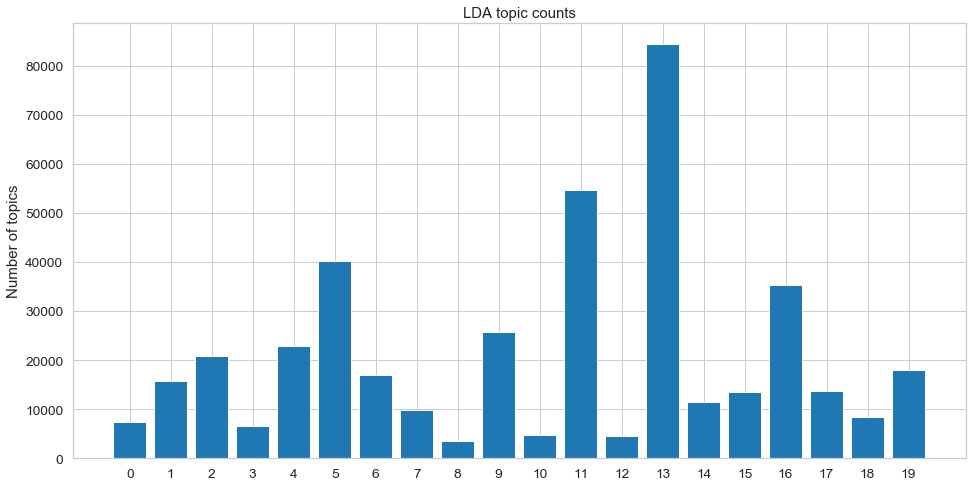

In [25]:
fig, ax = plt.subplots(figsize=(16,8))
ax.bar(lda_categories, lda_counts);
ax.set_xticks(lda_categories);
# ax.set_xticklabels(df_topic_keywords.values[:1]);
ax.set_title('LDA topic counts');
ax.set_ylabel('Number of topics');